In [1]:
source("/root/data/DBP_sa_bc/preprocess/utils.R")
setwd("/root/data/DBP_sa_bc/")
library(mclust) 
library(RColorBrewer)
# library(beeswarm)
library(ggbeeswarm)
library(gridExtra)
library(reshape2)
# library(ggrastr)

parser <- ArgumentParser()
parser$add_argument("--task", type = "character", default = "wnn_rna")
parser$add_argument("--method", type = "character", default = "DBP_sa_bc")
parser$add_argument("--exp", type = "character", default = "e1")
parser$add_argument("--init_model", type = "character", default = "sp_00001899")
parser$add_argument("--K", type = "integer", default = "38")
o <- parser$parse_known_args()[[1]]

K <- o$K
config <- parseTOML("configs/data.toml")[[o$task]]
subset_names <- basename(config$raw_data_dirs)
subset_ids <- sapply(seq_along(subset_names) - 1, toString)
# input_dirs <- pj("result", o$task, o$exp, "default", "predict", o$init_model, paste0("subset_", subset_ids))
if("DBP_sa_bc" %in% o$method){
    input_dir <- pj("result", "comparison", o$task, o$method, o$exp, o$init_model)
    output_dir <- pj("result", "comparison", o$task, o$method, o$exp, o$init_model, "fa", "figs")
}else if("mofa" %in% o$method | "liger" %in% o$method | "LDVAE" %in% o$method | "scETM" %in% o$method){
    input_dir <- pj("result", "comparison", o$task, o$method)
    output_dir <- pj("result", "comparison", o$task, o$method, "fa", "figs")
}

break_index_dir <- pj("result", o$task, o$exp, "default", "predict", o$init_model)
mkdir(output_dir, remove_old = F)
label_paths <- pj(config$raw_data_dirs, "label", "meta.csv")

dim_c <- parseTOML("configs/model.toml")[["default"]]$dim_c
qual_col_pals <- brewer.pal.info[brewer.pal.info$category == 'qual',]
dcols <- unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
l <- 5  # figure size
L <- 8   # figure size
m <- 0.5  # legend margin

Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: 'S4Vectors'


The following object is masked from 'package:future':

    values


The fol

In [2]:
label_list1 <- list()
label_list2 <- list()
label_list3 <- list()
subset_name_list <- list()
S <- length(subset_names)
for (i in seq_along(subset_names)) {
    subset_name <- subset_names[i]
    if ("lung_ts" %in% o$task){
        label_list1[[subset_name]] <- read.csv(label_paths[i], header = T)[, "Celltypes1"]
        label_list2[[subset_name]] <- read.csv(label_paths[i], header = T)[, "Celltypes_updated_July_2020"]
    }else if("wnn_rna" %in% o$task){
        label_list1[[subset_name]] <- read.csv(label_paths[i], header = T)[, "celltype.l1"]
        label_list2[[subset_name]] <- read.csv(label_paths[i], header = T)[, "celltype.l2"]
        label_list3[[subset_name]] <- read.csv(label_paths[i], header = T)[, "celltype.l3"]
    }else if("scsim1-10" %in% o$task){
        label_list1[[subset_name]] <- read.csv(label_paths[i], header = T)[, "celltypes"]
        label_list2[[subset_name]] <- read.csv(label_paths[i], header = T)[, "celltypes"]
        label_list3[[subset_name]] <- read.csv(label_paths[i], header = T)[, "celltypes"]
    }else if("ga" %in% o$task){
        label_list1[[subset_name]] <- read.csv(label_paths[i], header = T)[, "celltype"]
        label_list2[[subset_name]] <- read.csv(label_paths[i], header = T)[, "batch"]
        label_list3[[subset_name]] <- read.csv(label_paths[i], header = T)[, "celltype"]
    }
    # subset_name_list[[subset_name]] <- rep(subset_name, length(cell_name_list[[subset_name]]))
}

In [3]:
# Load data
pro <- read.csv(pj(input_dir, "proportion.csv"), header = TRUE)
# pro <- read.csv(pj(input_dir, "ZTZ.csv"), header = TRUE)
# z <- read.csv(pj(input_dir, "embeddings.csv"), header = TRUE)
# z <- z[-1, -1]
# z <- data.matrix(t(z))
labels1 <- do.call("c", unname(label_list1))
labels2 <- do.call("c", unname(label_list2))
# colnames(z) <- labels1
# rownames(z) <- paste0("F", seq_len(nrow(z)))
dim <- dim(pro)[2]-1

In [4]:
# Set colors
if ("wnn_rna" %in% o$task){
    batch_cols <- col_8
    celltype1_cols <- col_8
    celltype2_cols <- col_31
}else if("lung_ts" %in% o$task){
    batch_cols <- col_5
    celltype1_cols <- col_28
    celltype2_cols <- col_16
}else if("ga" %in% o$task){
    batch_cols <- col_5
    celltype1_cols <- col_16
    celltype2_cols <- col_28
}

### Plot point

In [5]:
# Get the name and the y position of each label
label_data <- data.frame(
  id=seq(1,K),
  individual=paste( "F", seq(1,K), sep=""),
  value=rep(1, K)
)
 
# calculate the ANGLE of the labels
number_of_bar <- nrow(label_data)
angle <-  90 - 360 * (label_data$id-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
label_data$hjust<-ifelse( angle < -90, 1, 0)
label_data$angle<-ifelse(angle < -90, angle+180, angle)

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


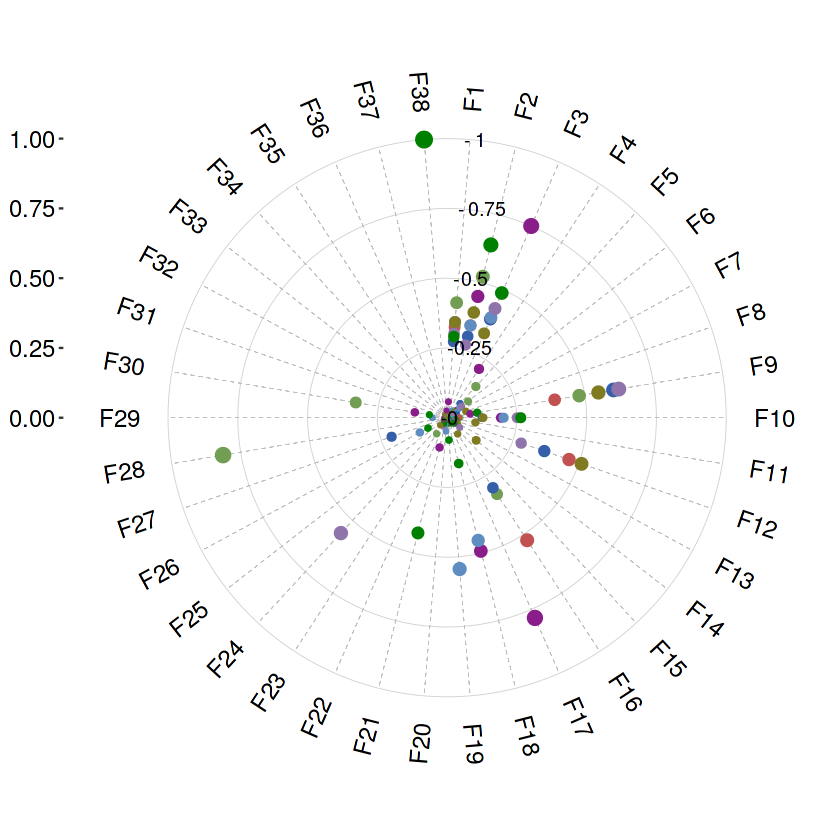

In [6]:
pro_long <- melt(pro, id.var = "Cell_type")
pro_long$value <- as.numeric(pro_long$value)

p <- ggplot(pro_long, aes(factor(variable, levels = unique(variable)), value, group = Cell_type, color = Cell_type, size=value)) +
geom_hline(
    aes(yintercept = y), 
    data.frame(y = c(0:4) * 0.25),
    color = "lightgrey",
    linewidth = 0.2,
    show.legend = F
  ) +
  geom_segment(
    aes(
      x = str_wrap(variable, 5),
      y = 0,
      xend = str_wrap(variable, 5),
      yend = 1
    ),
    linewidth = 0.1,
    linetype = "dashed",
    # color = "#c4c0c0",
    color = "gray",
    # alpha = 0.5,
    show.legend = F) +
    # geom_point(size = pro_long$value*4) +
    geom_point() +
    # scale_size(guide = guide_legend(title = "Value")) +
    scale_size_area(max_size = 4, guide = guide_legend(title = "Value")) +
    scale_color_manual(values = celltype1_cols, guide = guide_legend(title = "Cell type")) +
    coord_polar() +
    annotate("text", x=1, y=c(0.00, 0.25, 0.50, 0.75, 1.00), label="-", hjust=1, size=4) +
    annotate("text", x=1.1, y=c(0.00, 0.25, 0.50, 0.75, 1.00), label=c(0.00, 0.25, 0.50, 0.75, 1.00), hjust=0, size=4) +
    theme(
    # Set default color and font family for the text
    # text = element_text(color = "Black"),
    axis.title = element_blank(),
    # axis.text.x = element_blank(),
    axis.text = element_text(color = "Black", size = 14),
    axis.text.x = element_blank(),
    # Customize the text in the title, subtitle, and caption
    # plot.title = element_text(face = "bold", size = 25, hjust = 0.05),
    # plot.subtitle = element_text(size = 14, hjust = 0.05),
    # plot.caption = element_text(size = 6, hjust = .5), 
    # Make the background white and remove extra grid lines
    panel.background = element_rect(fill = "white", color = "white"),
    panel.grid = element_blank(),
    panel.grid.major.x = element_blank(),
    # set legend
    # legend.key = element_blank()
    legend.position = "none"
  ) +
  scale_x_discrete(limits = unique(pro_long$variable)) +
  geom_text(data=label_data, aes(x=id, y=value+0.1, label=individual, hjust=hjust), color="black", size=5, angle= label_data$angle, inherit.aes = FALSE) 
p

In [7]:
ggsave(p2, file = pj(output_dir, "cp_proportion.png"), width = 6, height = 6)
ggsave(p2, file = pj(output_dir, "cp_proportion.pdf"), width = 6, height = 6)

ERROR: Error in plot_theme(plot): object 'p2' not found
